In [1]:
using Downloads, LinearAlgebra, FFTW, Random
using CSV, DataFrames, DataFramesMeta
using Statistics, StatsPlots
using ForwardDiff
using Printf
using Plots

In [2]:
struct SourceLocalization
    c::Matrix{Float64} # 2x`m` matrix with the beacon positions
    d::Vector{Float64} # vector of distances (noisy)
    x::Vector{Float64} # true position (you're not meant to know this!)
end

In [3]:
function r(sl,x)
    rx = zeros(size(sl.c,2))
    for i in 1:size(sl.c,2)
        rx[i] = dot(x - sl.c[:,i], x - sl.c[:,i])  - sl.d[i]^2
    end
    return rx
end

function J(sl,x)
    Jx = zeros(size(sl.c)[2], length(x))
    for i in 1:size(sl.c)[2]
        Jx[i, :] .= 2 * x - 2 * sl.c[:, i]
    end
    return Jx
end

function Hr(sl,x,rx)
    Hrx = zeros(length(x), length(x))
    Hrx[1,1] = 2 * dot(ones(size(sl.c)[2]),rx)
    Hrx[2,2] = 2 * dot(ones(size(sl.c)[2]),rx)
    return Hrx
end

Hr (generic function with 1 method)

In [4]:
function gauss_newton(sl,x0, maxits=100, ϵ=1e-6, μ=1e-4)
    x = x0
    k = 0
    itn_err = Float64[]
    x1tr = Float64[]
    x2tr = Float64[]
    rx = r(sl, x)
    Jx = J(sl, x)    
    push!(x1tr,x0[1])
    push!(x2tr,x0[2])
    push!(itn_err,0.5*dot(rx, rx)) 
    for i in 1:maxits
        rx = r(sl,x)
        Jx = J(sl,x)
        dx = -Jx \ rx
        α = 1.0
        β = 0.5
        directional_derivative = (Jx'*rx)'*dx
        f_old = 0.5*dot(rx,rx)
        f_new = 0.5*dot(r(sl,x + α*dx),r(sl,x + α*dx))
        while f_new >= f_old + α *μ* directional_derivative
            α *= β
            f_new = 0.5*dot(r(sl,x + α*dx),r(sl,x + α*dx))
            if norm(α) < ϵ
                break
            end    
        end
        if norm(dx) < ϵ
            break
        end
        x += α*dx 
        k += 1
        push!(itn_err,0.5*dot(rx, rx))  
        push!(x1tr,x[1])
        push!(x2tr,x[2])
    end
    xtr= zeros(2,k+1)
    xtr[1,:] = vec(x1tr)
    xtr[2,:] = vec(x2tr ) 
    return x, k, itn_err, xtr
end

gauss_newton (generic function with 4 methods)

In [5]:
function gradient_descent(sl, x0, maxits=100, ϵ=1e-6, μ=1e-4)
    x = x0
    k = 0
    itn_err = Float64[]
    x1tr = Float64[]
    x2tr = Float64[]
    rx = r(sl, x)
    Jx = J(sl, x)    
    push!(x1tr,x0[1])
    push!(x2tr,x0[2])
    push!(itn_err,0.5*dot(rx, rx))  
    for i in 1:maxits
        rx = r(sl, x)
        Jx = J(sl, x)
        α = 1
        β = 0.5
        dx = -Jx' * rx
        directional_derivative = (Jx' * rx)' * dx
        f_old = 0.5 * dot(rx, rx)
        f_new = 0.5 * dot(r(sl, x + α * dx), r(sl, x + α * dx))
        while f_new >= f_old + α * μ * directional_derivative
            α *= β
            f_new = 0.5 * dot(r(sl, x + α * dx), r(sl, x + α * dx))
            if norm(α) < ϵ
                break
            end    
        end
        if norm(dx) < ϵ
            break
        end
        x += α * dx 
        k += 1
        push!(itn_err,0.5*dot(rx, rx)) 
        push!(x1tr,x[1])
        push!(x2tr,x[2])
    end
    xtr= zeros(2,k+1)
    xtr[1,:] = vec(x1tr)
    xtr[2,:] = vec(x2tr)   
    return x, k, itn_err, xtr
end


gradient_descent (generic function with 4 methods)

In [6]:
function generate_data(m, η=0.1)
    c = 2.0.*randn(2, m)  # beacon positions
    x = randn(2)     # true (unkown) position
    d = [norm(x - ci) + η*randn() for ci in eachcol(c)]
    return SourceLocalization(c , d, x)
end

generate_data (generic function with 2 methods)

In [7]:
function localize_source(sl,optimization,x0)
    xest, k, itn_err, xtr = optimization(sl, x0) 
    return xest, k, itn_err, xtr
end

localize_source (generic function with 1 method)

In [8]:
function plotmap(sl)
    scatter!(sl.c[1,:], sl.c[2,:], color=:green,label="beacons", shape=:square, ms=3)
    for i in 1:size(sl.c, 2)
        θ = LinRange(0, 2π, 100)  # Create points along the circumference
        cx = sl.c[1, i] .+ sl.d[i] * cos.(θ)  # x-coordinates of the circle points
        cy = sl.c[2, i] .+ sl.d[i] * sin.(θ)  # y-coordinates of the circle points
        plot!(cx, cy, label="Dist from b_$i",color=:black)
    end
    scatter!(sl.x[1,:], sl.x[2,:], color=:red,label="true position", shape=:cross, ms=10)
end


plotmap (generic function with 1 method)

In [9]:
function get_rgrid(sl, xar, nx1=200,nx2=200, mirgin=0.1)
    x1range = [minimum(xar[1,:]), maximum(xar[1,:])]
    x1range += mirgin.*[-1,1]
    x2range = [minimum(xar[2,:]), maximum(xar[2,:])]
    x2range += mirgin.*[-1,1]
    x1grid, x2grid, rgrid = zeros(nx1+1), zeros(nx2+1), zeros(nx1+1,nx2+1)

    for ix1 in 1:nx1+1
        x1grid[ix1] = (nx1 - ix1-1)/nx1*x1range[1] + (ix1-1)/nx1*x1range[2]
    end

    for ix2 in 1:nx2+1
        x2grid[ix2] = (nx2 - ix2 -1)/nx2*x2range[1] + (ix2-1)/nx2*x2range[2]
    end

    for ix2 in 1:nx2+1
        for ix1 in 1:nx1+1
            x = [x1grid[ix1],x2grid[ix2]]
            rx = r(sl, x)
            rgrid[ix2,ix1] = 0.5*dot(rx, rx)
        end
    end
    return x1grid, x2grid, rgrid 
end


get_rgrid (generic function with 4 methods)

In [18]:
m = 4
η= 0.1
sl = generate_data(m,η) 
x0 = randn(2)
xest1, k1, itn_err1, xtr1 = localize_source(sl, gradient_descent,x0)
xest2, k2, itn_err2, xtr2 = localize_source(sl, gauss_newton,x0)

([-2.4438982322003557, 0.16402842185338606], 43, [14.287469625336747, 14.287469625336747, 7.664492154653084, 6.858010029318721, 6.7204211181386375, 6.682893967072807, 6.668710069189374, 6.6621124149916096, 6.658571655147423, 6.656459754302535  …  6.638888354018831, 6.631743216115389, 6.616148942319182, 6.574097739406592, 6.416612802685928, 5.4348440836639345, 1.3948620961359826, 0.2708742928690277, 0.26305862517000606, 0.2630528531839891], [0.012295683587768735 -0.5672553327855133 … -2.4439103477665514 -2.4438982322003557; 1.5740445731041472 1.8464428605537777 … 0.16401132105946206 0.16402842185338606])

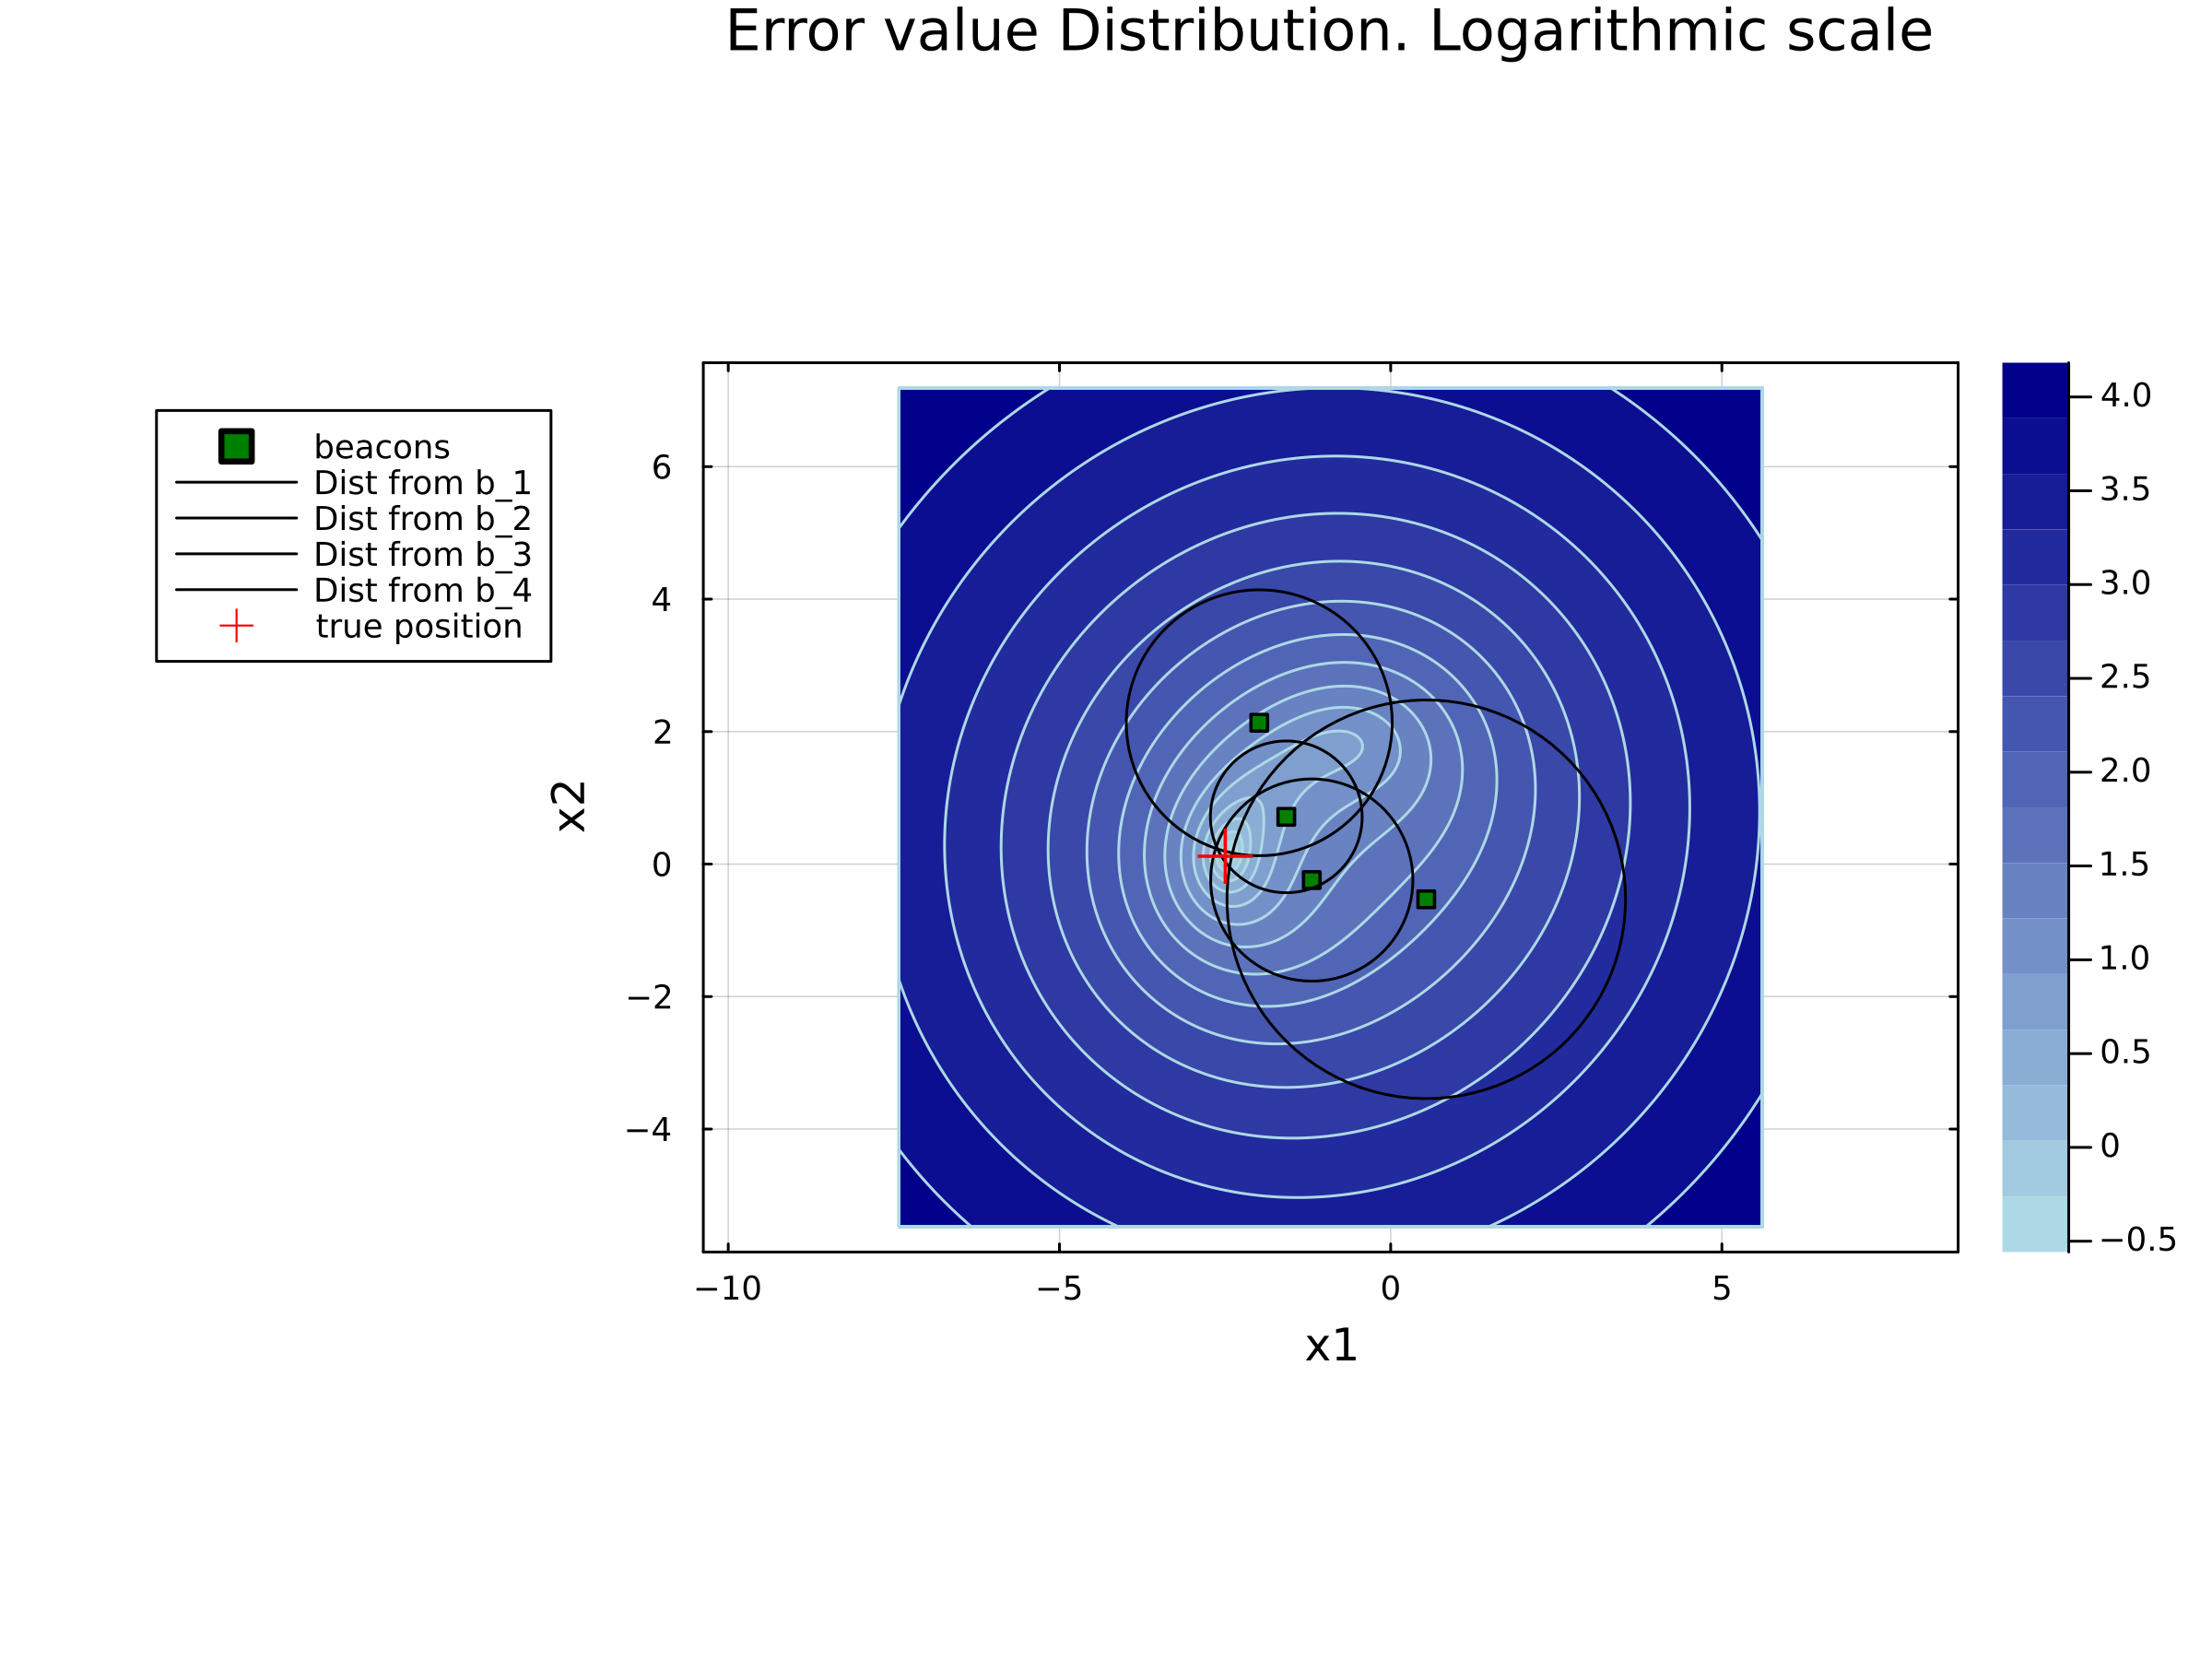

In [19]:
xar = hcat(sl.c, sl.x)
nx1, nx2, mirgin = 200, 200, 5
x1grid, x2grid, rgrid = get_rgrid(sl, xar, nx1, nx2, mirgin)
num_points = 20
tv = collect(range(log10(minimum(rgrid)), stop=log10(maximum(rgrid)), length=num_points))
tl = ["$(@sprintf("%.2e", 10^i))" for i in tv]
contourf(x1grid, x2grid, log10.(rgrid), colorbar_ticks=(tv, tl), color=:blues, lw=1 )  # Added cbar_label argument
plotmap(sl)
plot!(leg=:outertopleft, frame=:box, title="Error value Distribution. Logarithmic scale", 
    xlabel="x1", ylabel="x2", aspect_ratio=:equal, size=(800, 600), dpi=300)
#savefig("NLS_SL_ErrorDist.png")

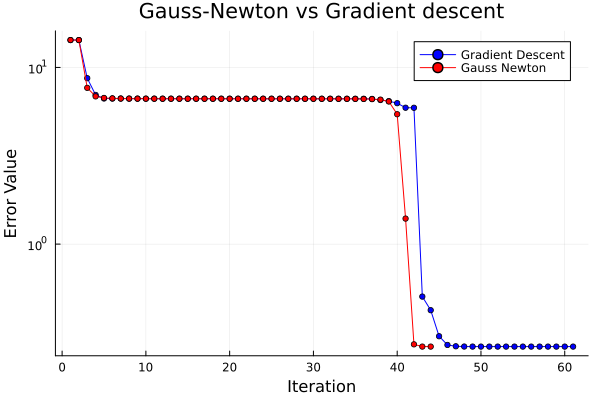

In [20]:
# Plot the error data
plot(itn_err1, label="Gradient Descent", yscale=:log10, markersize=3, color=:blue, marker=:circle)
plot!(itn_err2, label="Gauss Newton", yscale=:log10, markersize=3, color=:red, marker=:circle)
xlabel!("Iteration")
ylabel!("Error Value")
title!("Gauss-Newton vs Gradient descent")
#savefig("NLS_SL_ErrorItr.png")

In [21]:
min_value = minimum(itn_err1)
max_value = maximum(itn_err1)
num_points = 20
tv2 = collect(range(log10(min_value), stop=log10(max_value), length=num_points))
tl2 = ["$(@sprintf("%.2e", 10^i))" for i in tv]

20-element Vector{String}:
 "2.77e-01"
 "4.92e-01"
 "8.74e-01"
 "1.55e+00"
 "2.76e+00"
 "4.90e+00"
 "8.70e+00"
 "1.54e+01"
 "2.74e+01"
 "4.87e+01"
 "8.65e+01"
 "1.54e+02"
 "2.73e+02"
 "4.85e+02"
 "8.61e+02"
 "1.53e+03"
 "2.72e+03"
 "4.83e+03"
 "8.57e+03"
 "1.52e+04"

In [22]:
xar = hcat(sl.x, hcat(xtr1))
nx1,nx2, mirgin = 200,200,0.5
x1grid, x2grid, rgrid = get_rgrid(sl,xar,nx1,nx2,mirgin)

([-2.9912848285642917, -2.9736158510121897, -2.9559468734600878, -2.938277895907986, -2.920608918355884, -2.902939940803782, -2.88527096325168, -2.867601985699578, -2.849933008147476, -2.832264030595374  …  0.38348988388717753, 0.4011588614392795, 0.4188278389913814, 0.4364968165434833, 0.4541657940955853, 0.47183477164768717, 0.4895037491997891, 0.5071727267518911, 0.524841704303993, 0.542510681856095], [-0.3771702205264305, -0.36286809012865234, -0.3485659597308742, -0.334263829333096, -0.31996169893531784, -0.3056595685375396, -0.29135743813976145, -0.2770553077419833, -0.2627531773442051, -0.24845104694642695  …  2.3545366854491996, 2.368838815846978, 2.383140946244756, 2.3974430766425345, 2.4117452070403123, 2.426047337438091, 2.4403494678358686, 2.454651598233647, 2.4689537286314254, 2.4832558590292035], [13.453427600051258 12.771415503388479 … 86.87825172118184 88.00863771798416; 13.175073161022997 12.496787804409614 … 86.09073941615631 87.21221802032285; … ; 122.24625484135815 

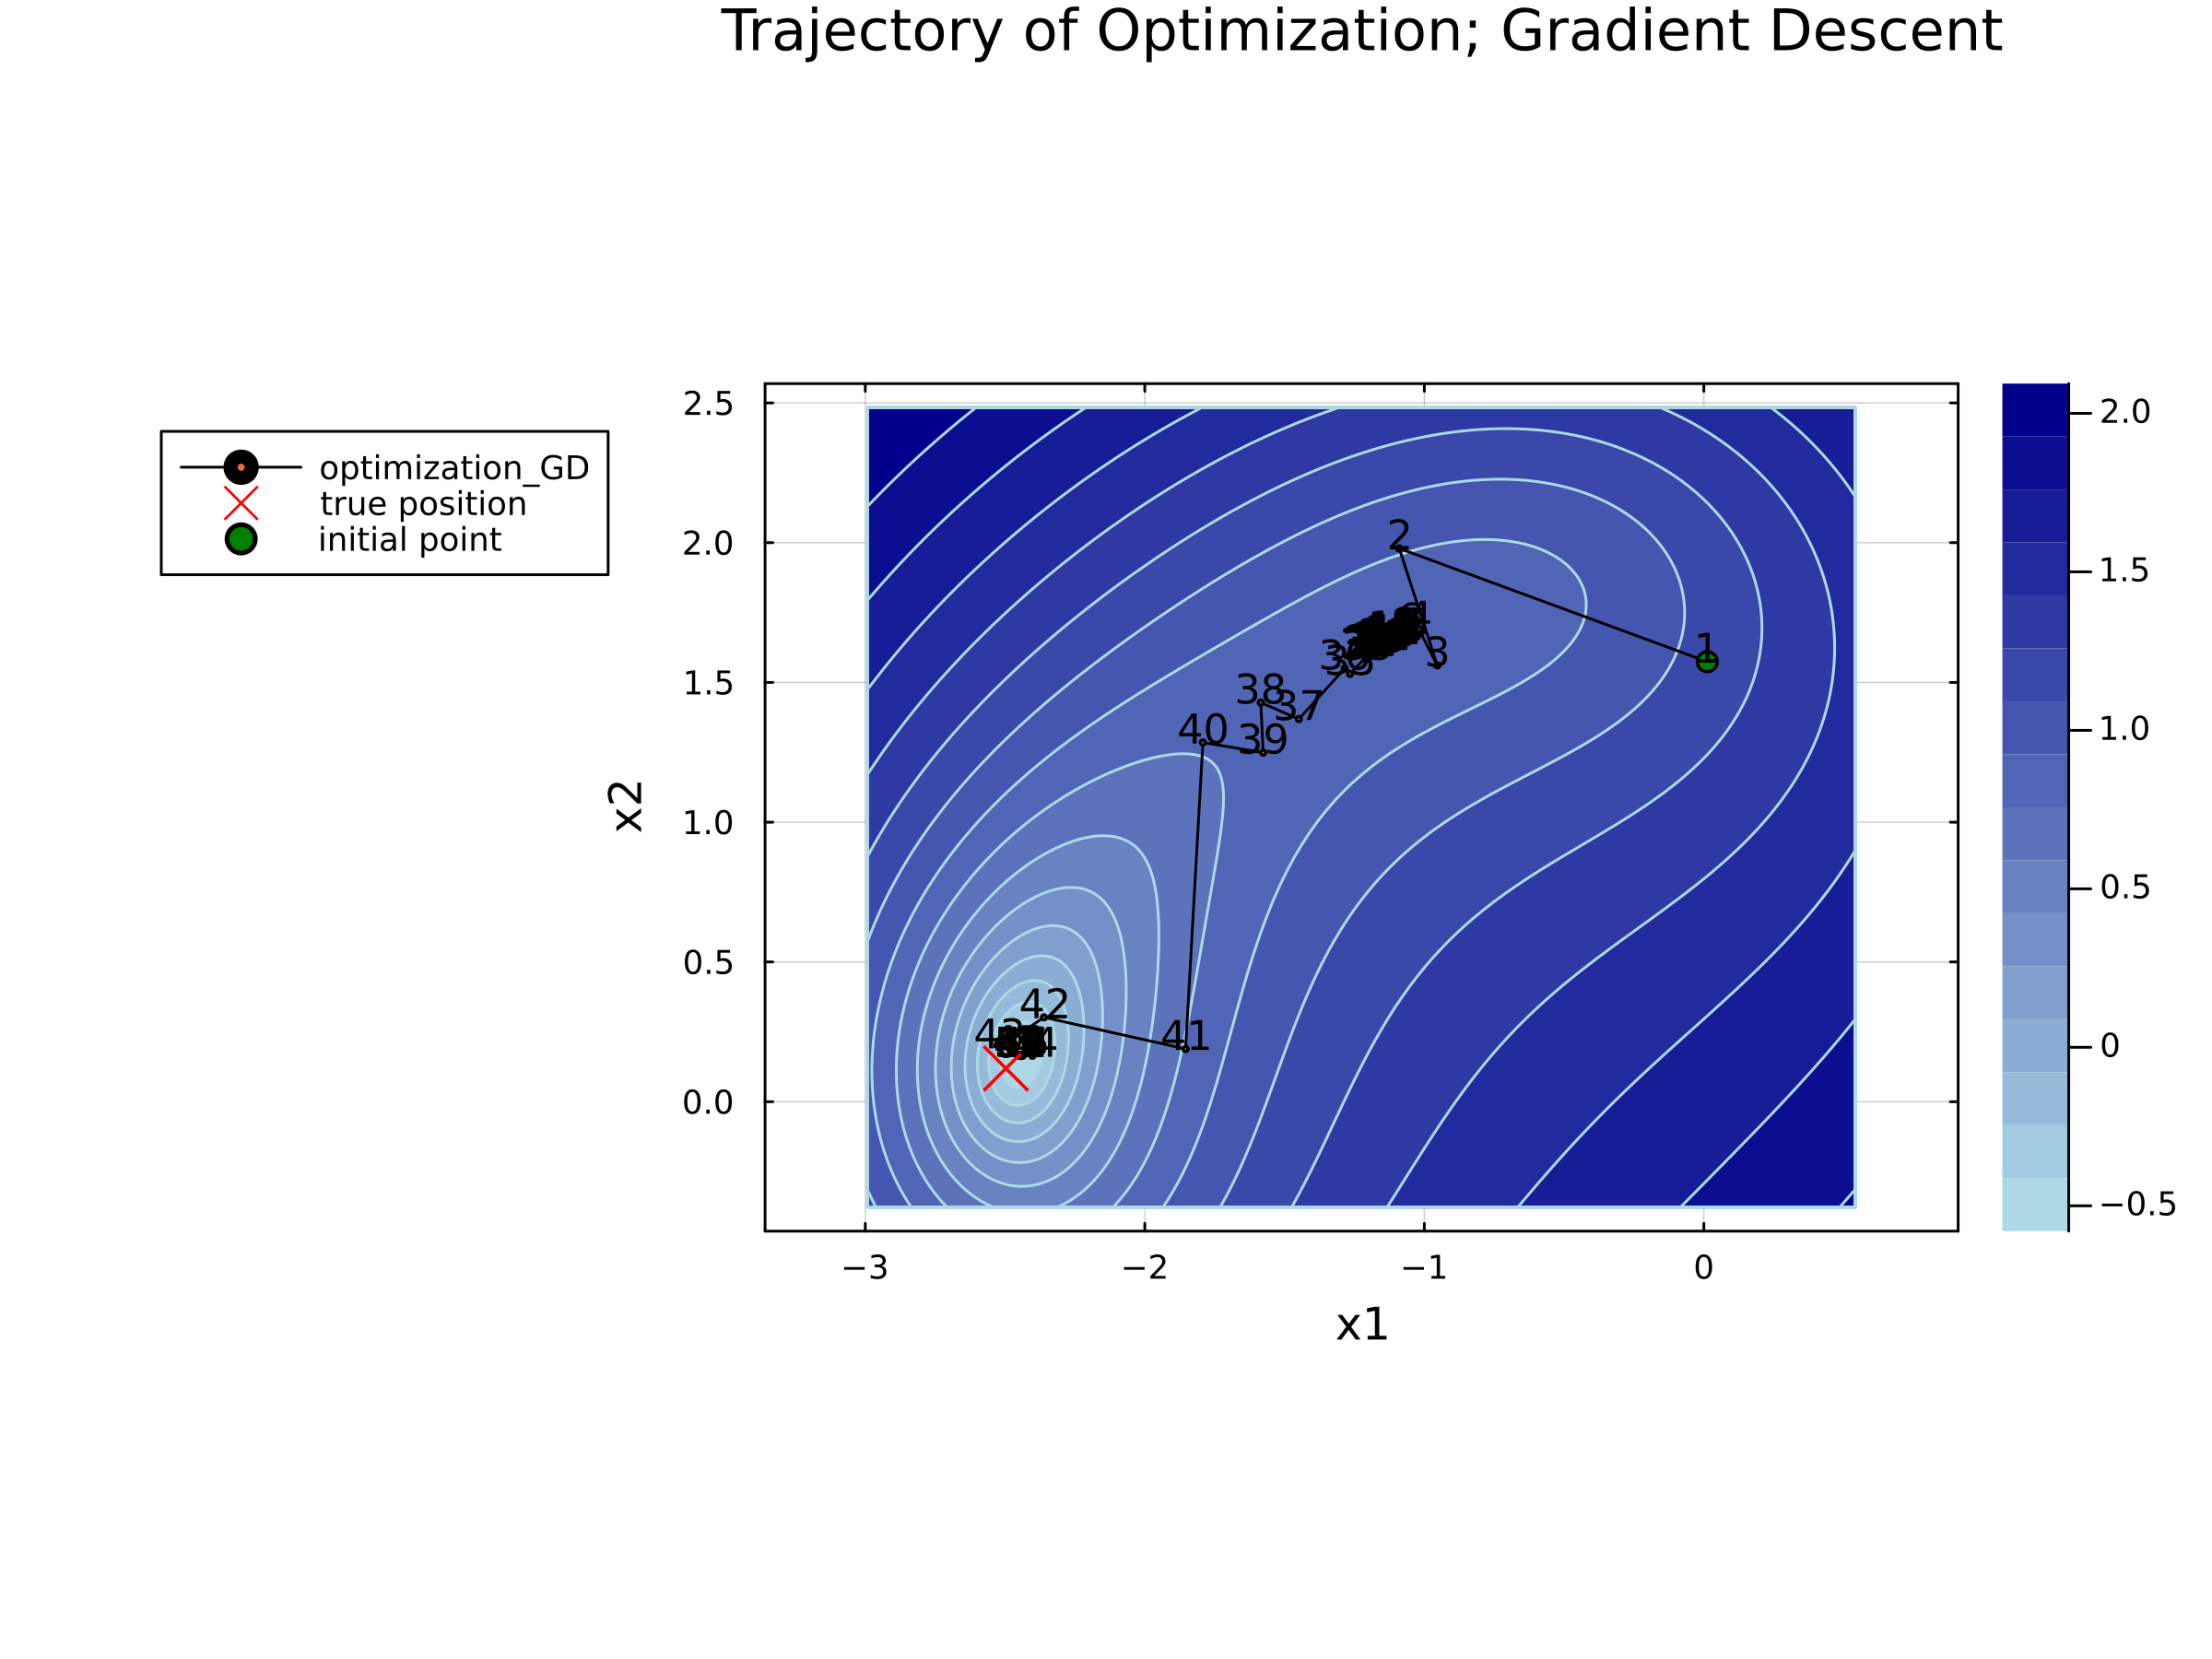

In [23]:
contourf(x1grid, x2grid, log10.(rgrid), colorbar_ticks=(tv2,tl2), color=:blues, label="Contour Levels")
plot!(xtr1[1,:], xtr1[2,:], linecolor=:black, marker=:circle, 
    markerstrokecolor=:black, markersize=1, label="optimization_GD")
indices = 1:size(xtr1, 2)  # Generate indices for each point
for i in 1:length(indices)
    annotate!(xtr1[1, i], xtr1[2, i] + 0.05, text(indices[i], :black, :center, 10))
end
scatter!(sl.x[1,:], sl.x[2,:], label="true position", color=:red,shape=:xcross, ms=8)
scatter!([x0[1]], [x0[2]], label="initial point", color=:green, shape=:circle, ms=4)
plot!(leg=:outertopleft, frame=:box, title="Trajectory of Optimization; Gradient Descent", 
    xlabel="x1", ylabel="x2", aspect_ratio=:equal, size=(800, 600), dpi=300)
#savefig("NLS_LS_GD_tr.png")

In [24]:
xar = hcat(sl.x, hcat(xtr2))
nx1,nx2, mirgin = 200,200,0.5
x1grid, x2grid, rgrid = get_rgrid(sl,xar,nx1,nx2,mirgin)

([-3.0606328698165646, -3.0426136496318756, -3.0245944294471863, -3.0065752092624973, -2.9885559890778075, -2.9705367688931186, -2.952517548708429, -2.9344983285237403, -2.916479108339051, -2.898459888154362  …  0.38103818545906687, 0.399057405643756, 0.4170766258284452, 0.4350958460131344, 0.4531150661978236, 0.4711342863825127, 0.4891535065672019, 0.5071727267518911, 0.5251919469365802, 0.5432111671212694], [-0.3771702205264305, -0.3635331061199928, -0.34989599171355507, -0.33625887730711734, -0.3226217629006796, -0.3089846484942418, -0.2953475340878041, -0.28171041968136634, -0.2680733052749286, -0.2544361908684909  …  2.2275186311031754, 2.2411557455096136, 2.254792859916051, 2.268429974322489, 2.2820670887289265, 2.2957042031353643, 2.309341317541802, 2.32297843194824, 2.336615546354678, 2.3502526607611154], [16.41832215406972 15.602771533672719 … 86.90046468937815 88.05386640691637; 16.138147616590654 15.326465194500813 … 86.14922674701975 87.29396297732974; … ; 114.1011219321823

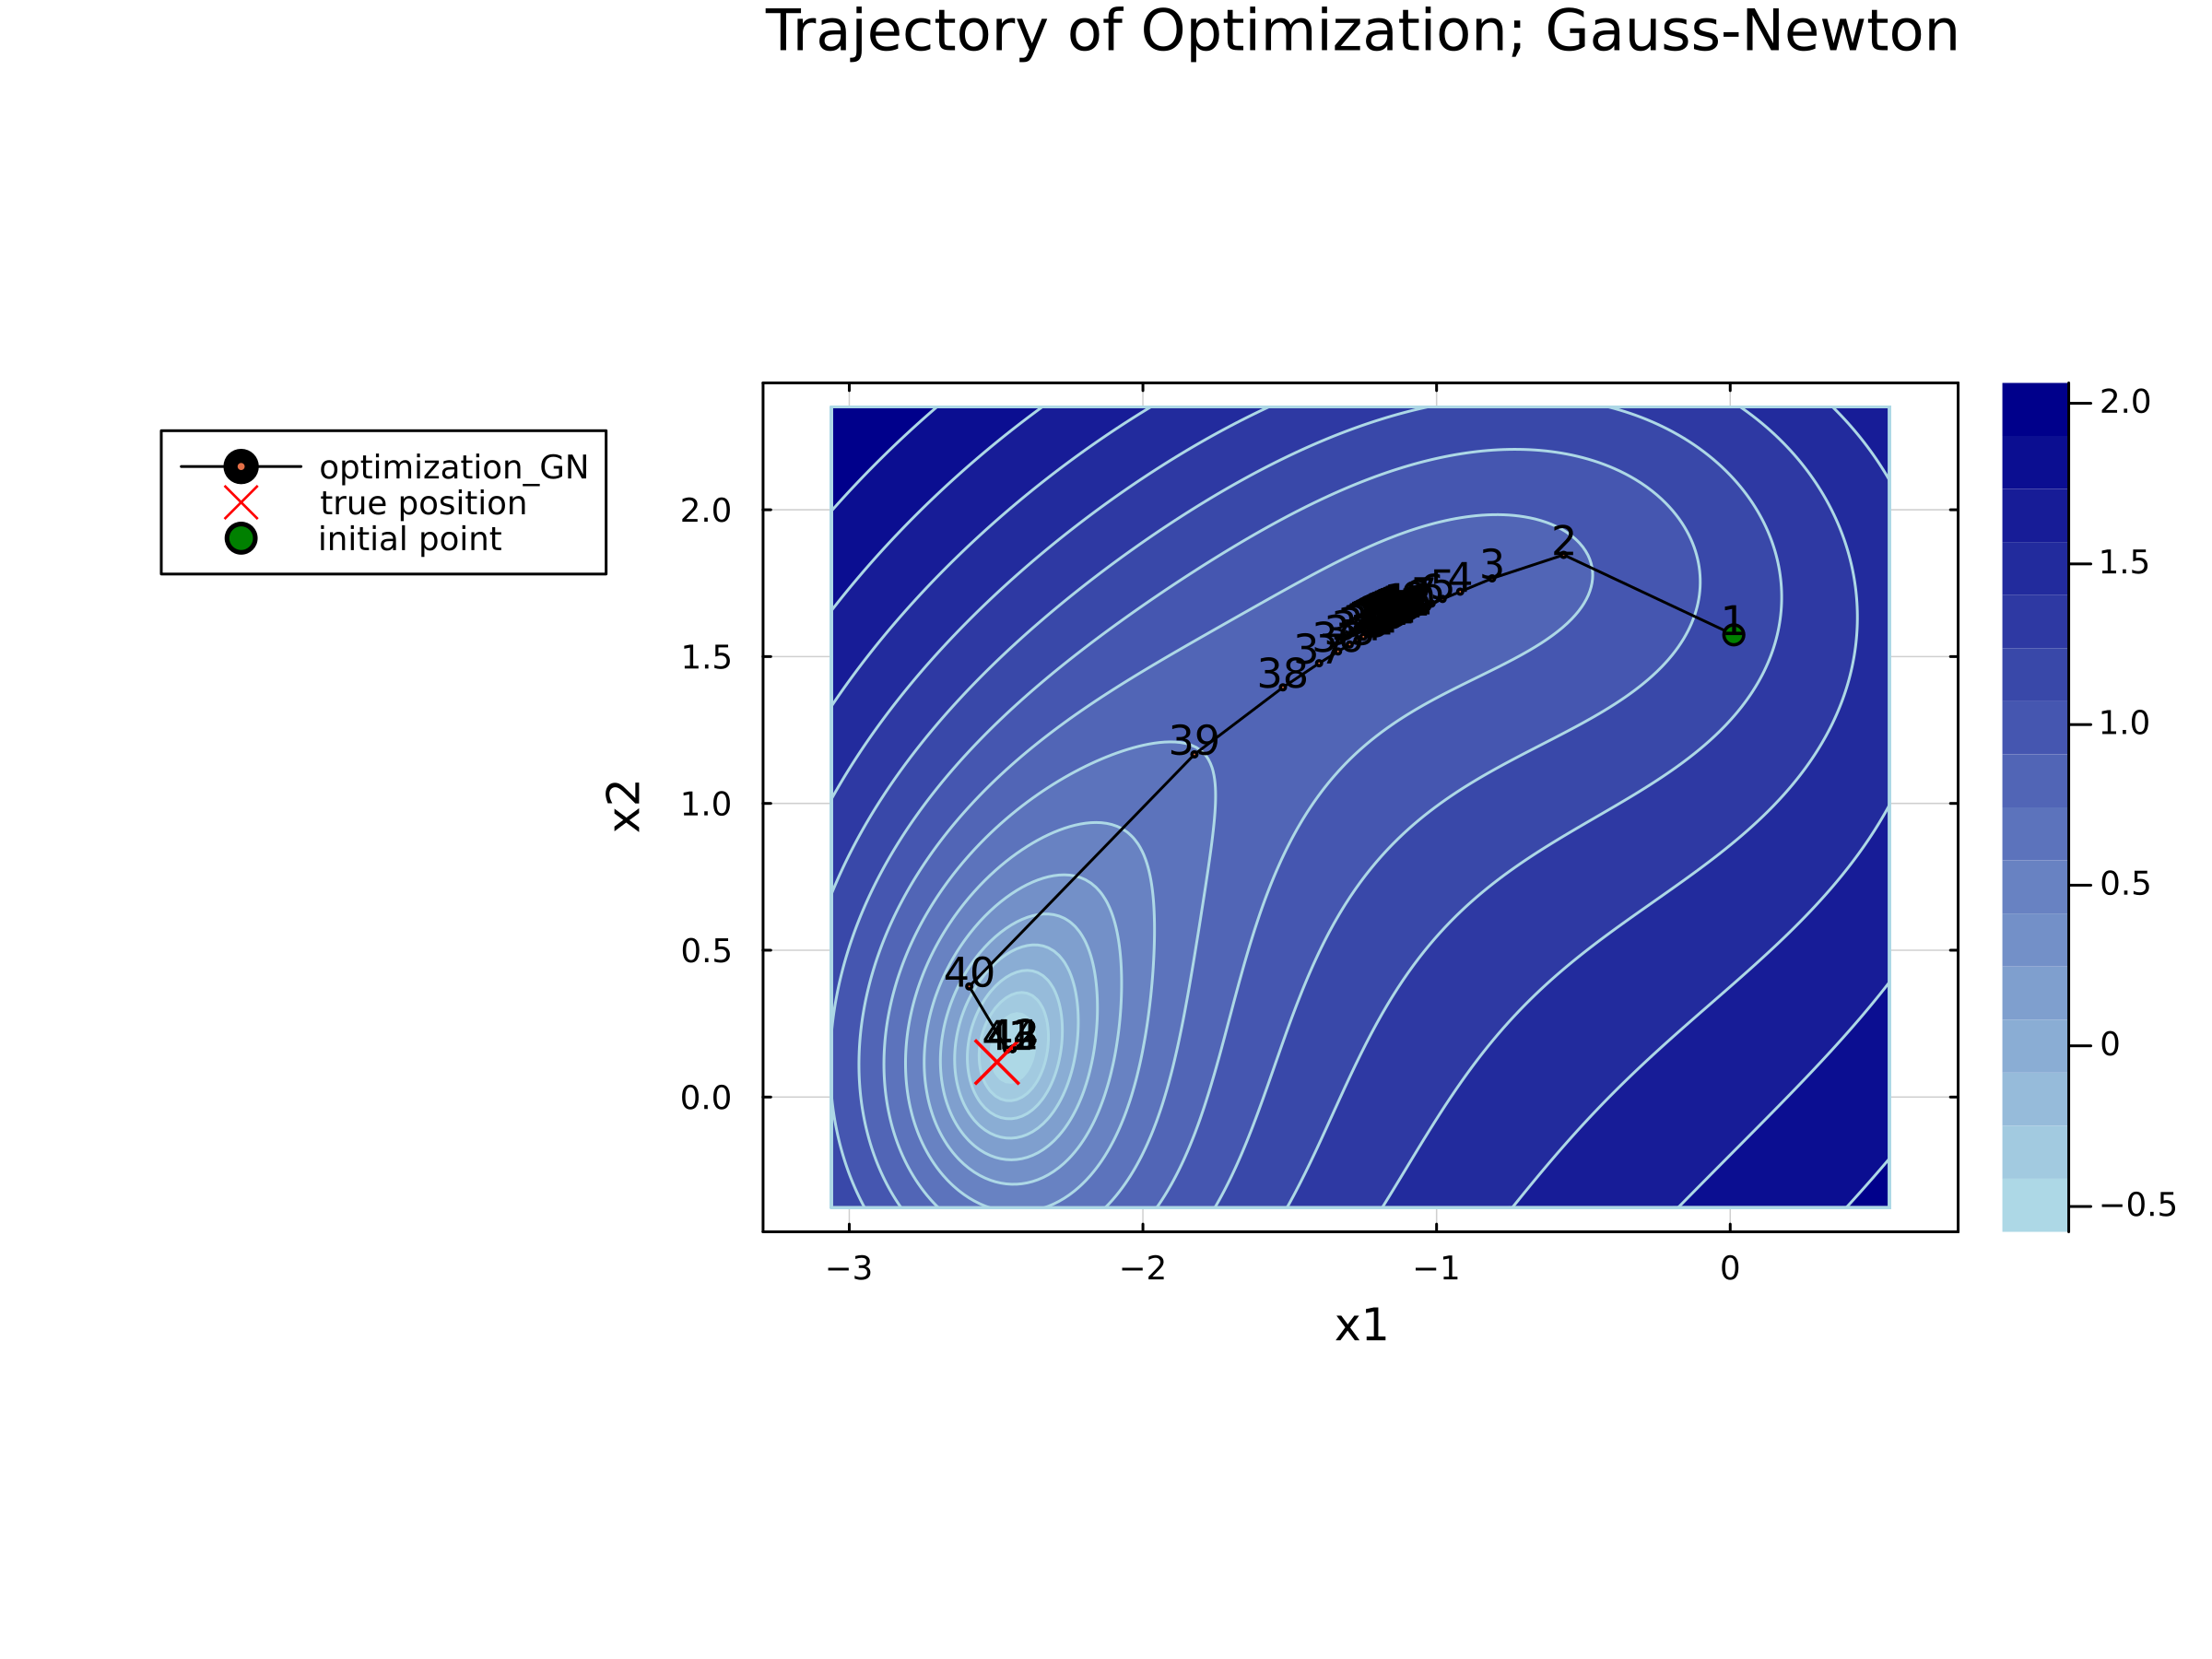

In [25]:
contourf(x1grid, x2grid, log10.(rgrid), colorbar_ticks=(tv2,tl2), color=:blues)
plot!(xtr2[1,:], xtr2[2,:], linecolor=:black, marker=:circle, 
    markerstrokecolor=:black, markersize=1, label="optimization_GN")

indices = 1:size(xtr2, 2)  # Generate indices for each point
for i in 1:length(indices)
    annotate!(xtr2[1, i], xtr2[2, i] + 0.05, text(indices[i], :black, :center, 10))
end
scatter!(sl.x[1,:], sl.x[2,:], label="true position", color=:red,shape=:xcross, ms=8)
scatter!([x0[1]], [x0[2]], label="initial point", color=:green, shape=:circle, ms=4)
plot!(leg=:outertopleft, frame=:box, title="Trajectory of Optimization; Gauss-Newton", 
    xlabel="x1", ylabel="x2", aspect_ratio=:equal, size=(800, 600), dpi=300)
#savefig("NLS_LS_GN_tr.png")